# COMP90051 Workshop 7
## Support Vector Machines
***
This worksheet consists of two parts:

1. **SVM hyperparameters**: we explore the effect of the penalty parameter and kernel
2. **Primal vs. dual**: we examine the computational efficiency of the primal and dual formulations in two different scenarios

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from timeit import default_timer as timer

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV

### 1. SVM hyperparameters
In this section, we'll explore how the SVM hyperparameters (i.e. the penalty parameter, the kernel, and any kernel parameters) affect the decision surface.

#### 1.1 Data set
To make visualisation and training easy, we'll consider a small binary classification data set called `cats.csv` (available from the LMS). 
It contains observations for 150 cats.
There are two features: heart and body weight measured in kilograms.
    The target variable is the sex of the cat (we encode 'male' as`-1` and 'female as `+1`).

\[Note: the data set originates from the following paper: R. A. Fisher (1947) _The analysis of covariance method for the relation between a part and the whole_, Biometrics **3**, 65–68\]

Ensure that `cats.csv` is located in the same directory as this notebook, then run the following code block to read the CSV file using `pandas`.

In [3]:
full_df = pd.read_csv('cats.csv')
full_df.SEX = full_df.SEX.map({'M': -1, 'F': 1})
full_df.head()

,HWT,BWT,SEX
0,2.0,7.0,1
1,2.0,7.4,1
2,2.0,9.5,1
3,2.1,7.2,1
4,2.1,7.3,1


Let's split the data into train/test sets so that we can evaluate our trained SVM.
(Note that this is likely to be unreliable for such a small data set.)

In [4]:
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=1)

Complete the code block below to standardise the features (heart and body weight), so that each feature has zero mean/unit variance.
(Hint: use the built-in `sklearn.preprocessing.StandardScaler`)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df.drop('SEX', axis = 1)) # fill in
Y_train = train_df.SEX # fill in

X_test = scaler.fit_transform(test_df.drop('SEX', axis = 1)) # fill in
Y_test = test_df.SEX # fill in

Below we plot the data. Notice that it's not linearly separable.

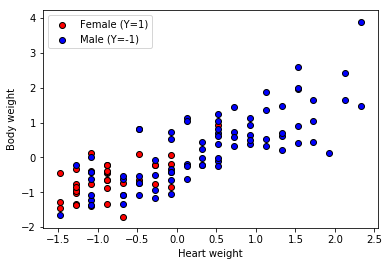

In [5]:
plt.scatter(X_train[Y_train==1,0], X_train[Y_train==1,1], label="Female (Y=1)", c='r', edgecolors='k')
plt.scatter(X_train[Y_train==-1,0], X_train[Y_train==-1,1], label="Male (Y=-1)", c='b', edgecolors='k')
plt.xlabel("Heart weight")
plt.ylabel("Body weight")
plt.legend()
plt.show()

#### 1.2 Parameter grid search
Since the data is clearly not linearly separable, we're going to fit a kernelised SVM.
To do this, we'll use the `sklearn.svm.SVC` class, which is a wrapper for the popular LIBSVM library.
For reference, note that LIBSVM solves the dual problem using a variant of SMO (sequential minimal optimisation).
The corresponding primal problem is as follows:
$$
\begin{align}
\min_{\mathbf{w}, b, \xi} \phantom{=} & \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{i = 1}^{n} \xi_i \\
      \mathrm{subject~to} \phantom{=} & y_{i}(\mathbf{w}^T \cdot \phi(\mathbf{x_i}) + b) \geq 1 - \xi_i \\
                          \phantom{=} & \xi_i \geq 0 \ \forall i
\end{align}
$$
Here $C$ is the penalty parameter, $\mathbf{w}$ are the weights, $b$ is the bias and $\phi$ is a mapping to a higher dimensional space---related to the kernel through $K(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j) \rangle$.
For now, we'll use the radial basis function (RBF) kernel, which is parameterised in terms of $\gamma$ as follows:
$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2)
$$

Returning to our classification problem: it's unclear how to set appropriate values for $C$ and $\gamma$ (named `C` and `gamma` in `sklearn`).
A simple way around this is to do an exhaustive grid search.
Below we define an evenly-spaced grid in log-space.

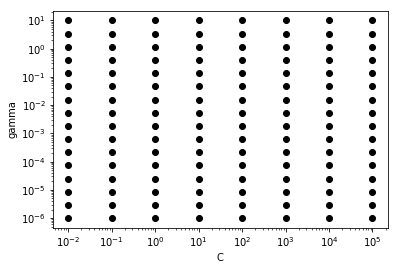

In [6]:
C_range = np.logspace(-2, 5, 8)
gamma_range = np.logspace(-6, 1, 16)

# Visualise the grid
xx, yy = np.meshgrid(C_range, gamma_range)
plt.plot(xx, yy, 'ko')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('gamma')
plt.show()

To do the grid search, we'll use the built-in `sklearn.model_selection.GridSearchCV` class.
It evaluates the model for each combination of parameter values using cross validation, and selects the combination with the best score.

We'll use `StratifiedShuffleSplit` for cross validation (it effectively generates bootstrap samples from the training data, while preserving the class ratio).

In [7]:
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.1, random_state=1)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid={'gamma': gamma_range, 'C': C_range}, cv=cv)
grid.fit(X_train, Y_train)
print("The best parameters are {0.best_params_} with a score of {0.best_score_:.3g}".format(grid))

The best parameters are {'C': 10.0, 'gamma': 0.04641588833612782} with a score of 0.828


**Question:** Why aren't we using k-fold cross validation?

Below we visualise the cross validation accuracy over the grid of parameters.

In [ ]:
scores = grid.cv_results_['mean_test_score'].reshape(C_range.size, gamma_range.size)

plt.figure(figsize=(8, 6))
plt.imshow(scores)
plt.colorbar(shrink=0.7)
plt.xticks(np.arange(len(gamma_range)), ["%.2e" % gamma for gamma in gamma_range], rotation=90)
plt.yticks(np.arange(len(C_range)), ["%1.e" % C for C in C_range])
plt.title('Cross validation accuracy')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

**Question:** Interpret this plot. Is there a clear winning combination of parameters?

Now that we've found the "best" parameters, let's fit the SVM on the entire training set (without cross-validation) so that we can evaluate on the test set. 

(Note: we actually fit all parameter combinations, as they're needed for a plot generated below.)

In [ ]:
classifiers = {(C, gamma) : SVC(C=C, gamma=gamma, kernel='rbf').fit(X_train, Y_train) 
               for C in C_range
               for gamma in gamma_range}

Complete the code block below to compute the test accuracy.

**Question:** How does this compare to the cross validation accuracy?

In [ ]:
best_params = (grid.best_params_["C"], grid.best_params_["gamma"])
best_svm = classifiers[best_params]
best_acc = ... # fill in
print("The SVM with parameters C={0[0]:.3g}, gamma={0[1]:.3g} has test accuracy {1:.3g}.".format(best_params, best_acc))

Below we visualise the decision functions for all parameter combinations (double-click output to expand to 100%)

In [ ]:
fig, axarr = plt.subplots(C_range.size, gamma_range.size, figsize=(50,20))
border = 0.2

# Build meshgrid over the feature space
X_min = np.amin(X_train, axis=0)
X_max = np.amax(X_train, axis=0)
xx, yy = np.meshgrid(np.linspace(X_min[0] - border, X_max[0] + border, 100), 
                     np.linspace(X_min[1] - border, X_max[1] + border, 100))

# Plot training data + decision function for all feature combinations
for (i, C) in enumerate(C_range):
    for (j, gamma) in enumerate(gamma_range):
        clf = classifiers[(C, gamma)]
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        axarr[i,j].set_title("gamma={0.gamma:.3g}; C={0.C:.3g}".format(clf), 
                           size='medium')

        axarr[i,j].pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
        axarr[i,j].scatter(X_train[Y_train==1,0], X_train[Y_train==1,1], c='r', edgecolors='k')
        axarr[i,j].scatter(X_train[Y_train==-1,0], X_train[Y_train==-1,1], c='b', edgecolors='k')
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
        axarr[i,j].axis('tight')
plt.show()

**Question:** Explain how `gamma` and `C` affect the decision surface qualitatively.

**Extension activity:** Re-run this section using a different kernel (e.g. the built-in polynomial kernel or a custom kernel).

### 2. Primal vs dual
In this section, we'll compare the computational efficiency of two linear SVM implementations: in the primal and dual formulations.
We'll use the `sklearn.svm.LinearSVC` class, which is a wrapper for LIBLINEAR (from the same authors as LIBSVM, but optimised for the linear kernel).

_Note: LIBLINEAR does not implement a primal-based method for the regular hinge loss SVM.
Hence, we'll work with the squared-hinge loss SVM, for which both primal- and dual-based methods are available._

#### 2.1 Data set
Below we define a random generator for synthetic binary classification data sets.
Our reasons for doing this are twofold:
* we should compare the SVM implementations on a variety of data sets (a single data set may favour one of the methods)
* we should ensure the same sequence of data sets are used for each benchmark (by setting the random seed)

In [ ]:
from sklearn.datasets import make_classification
class DataGenerator(object):
    def __init__(self, n_instances, n_features, n_datasets, random_seed=1):
        """
        Arguments
        =========
        n_instances : int
            number of instances
        n_features : int
            number of features
        n_datasets : int
            number of data sets to generate before stopping
        """
        self.ctr = 0
        self.n_datasets = n_datasets
        self.n_instances = n_instances
        self.n_features = n_features
        self.rng = np.random.RandomState(random_seed)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
        
    def next(self):
        """
        Returns
        =======
        X : numpy array, shape: (n_instances, n_features)
            feature matrix
        Y : numpy array, shape: (n_instances,)
            target class labels relative to X
        """
        if (self.ctr < self.n_datasets):
            self.ctr += 1
            return make_classification(n_samples=self.n_instances, n_features=self.n_features, 
                                       n_informative=10, n_classes=2, n_clusters_per_class=3, 
                                       flip_y=0.01, class_sep=0.8, random_state=self.rng)
        else:
            raise StopIteration()

#### 2.2 Benchmark
Below we define a function that takes a `LinearSVC` instance as input (either the dual or primal) and runs a benchmark.
The benchmark is to fit the SVM on all of the data sets produced by a `DataGenerator` instance.
We compute the mean training time with standard error, as well as the mean accuracy (over all data sets).

In [ ]:
def benchmark(clf, data_generator):
    """
    Benchmarks a classifier.
    
    clf : a sklearn classifier
    data_generator : a DataGenerator instance
    """
    traintimes = np.empty(data_generator.n_datasets, dtype=np.float)
    accuracies = np.empty(data_generator.n_datasets, dtype=np.float)
    for (i, (X, Y)) in enumerate(data_generator):
        start = timer()
        clf.fit(X,Y)
        end = timer()
        traintimes[i] = end - start
        accuracies[i] = clf.score(X, Y)
    
    mean_traintime = np.mean(traintimes)
    stderr_traintime = np.std(traintimes)/np.sqrt(traintimes.size)
    mean_acc = np.mean(accuracies)
    
    print("Training time: {:.3g} ± {:.1g} s. Mean accuracy: {:.3g}.".format(mean_traintime, stderr_traintime, mean_acc))

Now we define the primal and dual `LinearSVC` instances and then run the benchmarks in different scenarios.

In [ ]:
clf_primal = LinearSVC(dual=False, C=1.0)
clf_dual = LinearSVC(dual=True, C=1.0)

In [ ]:
# n_instances >> n_features, primal
benchmark(...) # fill in

In [ ]:
# n_instances >> n_features, dual
benchmark(...) # fill in

In [ ]:
# n_features >> n_instances, primal
benchmark(...) # fill in

In [ ]:
# n_features >> n_instances, dual
benchmark(...) # fill in

**Question:** What do you observe?